# 09. Линейная алгебра

# Защита персональных данных клиентов

Нам необходимо **защитить данные клиентов** страховой компании «Хоть потоп». Разработаем такой метод преобразования данных, чтобы по ним было сложно восстановить персональную информацию. После этого обоснуем корректность его работы.

Нужно защитить данные, чтобы при преобразовании качество моделей машинного обучения не ухудшилось. Подбирать наилучшую модель не требуется.

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Загрузка-данных" data-toc-modified-id="Загрузка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Загрузка данных</a></span></li><li><span><a href="#Умножение-матриц" data-toc-modified-id="Умножение-матриц-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Умножение матриц</a></span></li><li><span><a href="#Алгоритм-преобразования" data-toc-modified-id="Алгоритм-преобразования-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Алгоритм преобразования</a></span></li><li><span><a href="#Проверка-алгоритма" data-toc-modified-id="Проверка-алгоритма-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Проверка алгоритма</a></span></li></ul></div>

## Загрузка данных

In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression

In [2]:
df = pd.read_csv('insurance.csv')

Загрузили данные. Посмотрим, что они из себя представляют.

In [3]:
df.head()

,Пол,Возраст,Зарплата,Члены семьи,Страховые выплаты
0,1,41.0,49600.0,1,0
1,0,46.0,38000.0,1,1
2,0,29.0,21000.0,0,0
3,0,21.0,41700.0,2,0
4,1,28.0,26100.0,0,0


Таблица содержит:
1. **Признаки:** пол, возраст, зарплата застрахованного и количество членов его семьи.
2. **Целевой признак:** количество страховых выплат клиенту за последние 5 лет.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Пол                5000 non-null   int64  
 1   Возраст            5000 non-null   float64
 2   Зарплата           5000 non-null   float64
 3   Члены семьи        5000 non-null   int64  
 4   Страховые выплаты  5000 non-null   int64  
dtypes: float64(2), int64(3)
memory usage: 195.4 KB


In [5]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Пол,5000.0,0.4990,0.500049,0.0,0.0,0.0,1.0,1.0
Возраст,5000.0,30.9528,8.440807,18.0,24.0,30.0,37.0,65.0
Зарплата,5000.0,39916.3600,9900.083569,5300.0,33300.0,40200.0,46600.0,79000.0
Члены семьи,5000.0,1.1942,1.091387,0.0,0.0,1.0,2.0,6.0
Страховые выплаты,5000.0,0.1480,0.463183,0.0,0.0,0.0,0.0,5.0


Видим, что датафрейм содержит 5000 объектов и 5 признаков. Пропущенных значений нет. На данном этапе можем утверждать, что данные корректные, значения для каждого из признаков не противоречат здравому смыслу.

С другой стороны, необходимо отметить, что потребуются следующие преобразования:
- названия признаков задать латинскими буквами и перевести в нижний регистр;
- преобразовать типы данных признаков `Возраст` и `Зарплата` в целочисленный;
- проверить датафрейм на предмет наличия повторяющихся значений.

Произведем эти преобразования.

In [6]:
df.columns = ['gender', 'age', 'salary', 'family_members', 'insurance_benefits']

In [7]:
df[['age', 'salary']] = df[['age', 'salary']].astype('int')

Последним действием будем проверка повторяющихся значений.

In [8]:
df.duplicated().sum()

153

Получили 153 повторяющихся объектов, которые необходимо убрать из рассматриваемого датафрейма.

In [9]:
df = df.drop_duplicates().reset_index(drop=True)

Проверим результаты совершенных преобразований.

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4847 entries, 0 to 4846
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype
---  ------              --------------  -----
 0   gender              4847 non-null   int64
 1   age                 4847 non-null   int32
 2   salary              4847 non-null   int32
 3   family_members      4847 non-null   int64
 4   insurance_benefits  4847 non-null   int64
dtypes: int32(2), int64(3)
memory usage: 151.6 KB


**Вывод**

Загрузили и изучили данные:
- выполнили преобразование типов данных;
- изменили названия признаков на латинские наименования в нижнем регистре;
- проверили пропущенные значения и избавились от повторяющихся объектов.

## Умножение матриц

По условию задачи, от нас требуется ответ на вопрос: `Как изменится качество линейной регрессии, если матрицу признаков умножить на обратимую матрицу?`.


Обозначения:

- $X$ — матрица признаков (нулевой столбец состоит из единиц)

- $y$ — вектор целевого признака

- $P$ — матрица, на которую умножаются признаки

- $w$ — вектор весов линейной регрессии (нулевой элемент равен сдвигу)

Также нам потребуются свойства обратных матриц и транспонированных матриц. Для матриц $A$ и $B$ справедливо:

$$
(A B)^{-1} = B^{-1} A^{-1} \ \ \ \ \ \ (свойство\ 1)
$$

$$
(A B)^T = B^T A^T \ \ \ \ \ \ \ \ \ \ \ (свойство\ 2)
$$

$$
(A^T)^{-1} = (A^{-1})^T \ \ \ \ \ \ \ \ \ (свойство\ 3)
$$

$$
(A^{-1})^{-1} = A \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ (свойство\ 4)
$$

Формула предсказаний выглядит следующим образом:

$$
a = Xw
$$

Задача обучения линейной регрессией заключается в нахождении такого значения вектора весов $w$, при котором средняя квадратичная ошибка между предсказанными значениями и действительными **наименьшая**:

$$
w = \arg\min_w MSE(Xw, y)
$$

Минимальное значение $MSE$ получается, когда веса равны этой величине::

$$
w = (X^T X)^{-1} X^T y
$$

Подытожим, от нас **требуется нахождение величины $a_{new}=X_{new}w_{new}$ и ее сравнение с величиной $a$.**

Поскольку матрица признаков $X$ умножается на обратимую матрицу $P$, то $X_{new}=XP$

Теперь найдем значение $w_{new}$. Для этого в формулы для нахождения $w$ подставим вместо $X$ выражение $XP$.

$$
w_{new} = ((XP)^T (XP))^{-1} (XP)^T y
$$

Начнем преобразование правой части данного равенства. Используя свойство 2 получим:

$$
w_{new} = (P^T X^T X P)^{-1} (XP)^T y
$$

Первую скобку раскроем, используя свойство 1 (предварительно сгруппировав $X^T X$), а для второй скобки применим свойство 2.

$$
w_{new} = P^{-1} (X^T X)^{-1} (P^T)^{-1} P^T X^T y
$$

К $(P^T)^{-1}$ применим свойство 3 и получим: $(P^{-1})^T$ 

Тогда $w_{new}$ запишется следующим образом:

$$
w_{new} = P^{-1} (X^T X)^{-1} (P^{-1})^T P^T X^T y
$$

Далее необходимо использовать свойство 2 к выражению $(P^{-1})^T P^T$. В результате получим:

$$
w_{new} = P^{-1} (X^T X)^{-1} (P P^{-1})^T X^T y
$$

Нам известно, что матрица $P$ - обратимая, значит для нее выполняется условие:

$$
PP^{-1}=P^{-1}P=E,
$$
где $E$ - единичная матрица.

Также стоит отметить, что для единичной матрицы справедливо:

$$
E^T = E
$$

$$
A E = E A = A
$$

Принимая во внимание вышеуказанные свойства получаем следующее выражение для вычисления вектора весов $w_{new}$:

$$
w_{new} = P^{-1} (X^T X)^{-1} X^T y,
$$
что равносильно
$$
w_{new} = P^{-1} w
$$

Мы нашли оба множителя для нахождения искомой величины $a_{new}$. Подставим их:

$$
a_{new} = X_{new}w_{new} = X P P^{-1} w = X w
$$

**В итоге получаем, что $a_{new} == a$**

**Вывод**

Произведя необходимые преобразования, мы можем сказать, что при умножении признаков на обратимую матрицу, **качество линейной регрессии не изменится**, что подтверждается приведенной нами вычислениями.

## Алгоритм преобразования

Предложим свой алгоритм преобразования данных для решения задачи. 

**Алгоритм**

Матрица признаков $X$ умножается справа на обратимую матрицу $P$, а затем, полученная матрица умножается справа на $Q^{-1}$, при условии что $P\neq Q$.

Докажем, почему качество линейной регрессии не поменяется.

**Обоснование**

Как и в предыдущем пункте, от нас требуется нахождение величины $a_{new}=X_{new}w_{new}$ и ее сравнение с величиной $a=X w$.

По предложенному нами алгоритму, $X_{new} = X P Q^{-1}$

Теперь найдем значение $w_{new}$. Для этого в формулы для нахождения $w$ подставим вместо $X$ выражение $X P Q^{-1}$.

$$
w_{new} = ((X P Q^{-1})^T (X P Q^{-1}))^{-1} (X P Q^{-1})^T y
$$

**Пояснение:** дальнейшие преобразования будем производить аналогично п.2 (опираясь на свойства 1, 2, 3 и 4). Чтобы исключить дублирование пояснений, запишем преобразования одной строкой.

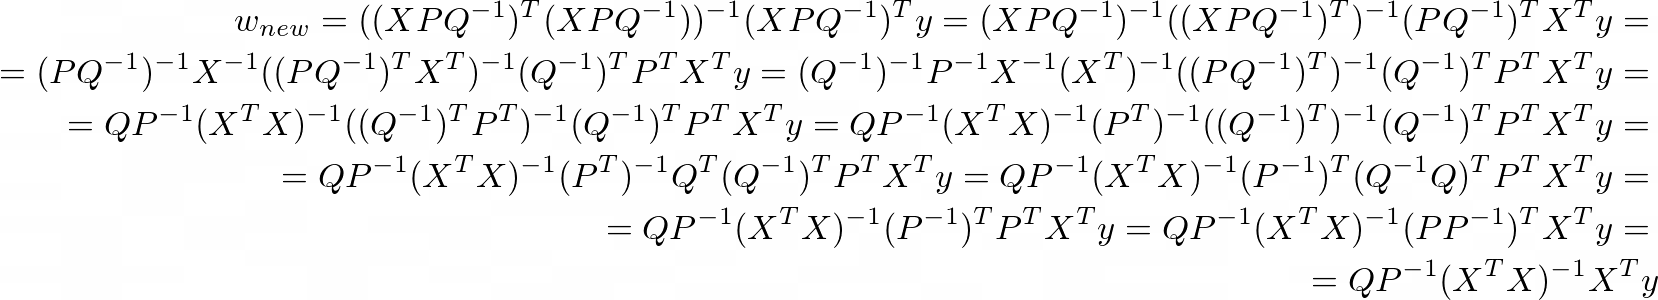

Вспомним, что $w = (X^T X)^{-1} X^T y$, получаем: $w_{new} = Q P^{-1} w$

Тогда $$
a_{new} = X_{new}w_{new} = X P Q^{-1} Q P^{-1} w = X P P^{-1} w = X w = a
$$


**Вывод:** 

Предложенный нами алгоритм преобразований **не влияет на качество линейной регрессии**, можем применять его на практике.

## Проверка алгоритма

Проверим предложенный нами в предыдущем пункте алгоритм преобразований данных.

Для начала построим модель линейной регрессии до преобразований и вычислим ее качество метрикой $R^2$. Преждем чем обучать модель, выделим целевой признак из входных данных.

In [11]:
features = df.drop('insurance_benefits', axis=1)
target = df['insurance_benefits']

In [12]:
model = LinearRegression()
model.fit(features, target)
predictions_before = model.predict(features)

In [13]:
R2_before = r2_score(target, predictions_before)
R2_before

0.4302010046633359

Получили значение метрики $R^2 = 0.4302$. Теперь можем провести преобразования с исходными данными.

Для реализации алгоритма нам требуется 2 обратимые матрицы $P$ и $Q$. Поскольку в исходных данных 4 признака (`gender`, `age`, `salary`, `family_members`), следовательно требуется подобрать обратимые матрицы размерностью 4x4.

In [14]:
P = np.random.rand(4,4)
P

array([[0.06223423, 0.19809339, 0.30912551, 0.29555874],
       [0.98458985, 0.46836129, 0.38637345, 0.69880467],
       [0.02622681, 0.38545033, 0.40604704, 0.368657  ],
       [0.72085377, 0.46989122, 0.70073683, 0.11630212]])

In [15]:
Q = np.random.rand(4,4)
Q

array([[0.63953747, 0.03592867, 0.8746899 , 0.63599093],
       [0.07911947, 0.45876554, 0.94547697, 0.38755717],
       [0.83821243, 0.22652918, 0.78525108, 0.19305442],
       [0.53224482, 0.79132025, 0.64501737, 0.58806887]])

Проверим, есть ли у матриц $P$ и $Q$ обратные.

In [16]:
P_inv = np.linalg.inv(P)
P_inv

array([[-2.07074610e-01,  7.17327755e-01, -1.34331437e+00,
         4.74221490e-01],
       [-1.00324801e+01,  4.37917344e-01,  7.21134486e+00,
         5.63795092e-03],
       [ 6.35964625e+00, -1.15897797e+00, -3.26541547e+00,
         1.15276042e+00],
       [ 3.49956226e+00,  7.67626745e-01, -1.13512588e+00,
        -1.30930763e+00]])

In [17]:
Q_inv = np.linalg.inv(Q)
Q_inv

array([[ 0.04634739, -1.15205445,  1.03104858,  0.37064019],
       [-1.2432355 ,  0.20060946,  0.2019074 ,  1.14605582],
       [-0.12569799,  1.34444362,  0.56256   , -0.93477261],
       [ 1.76885177, -0.70189192, -1.82190337,  0.84815927]])

Обратные матрицы $P^{-1}$ и $Q^{-1}$ существуют, значит матрицы $P$ и $Q$ являются обратимыми, а это удовлетворяет условиям, заданным в нашем алгоритме.

Преобразуем исходные признаки.

In [18]:
# алгоритм преобразования исходных объектов
features_new =  pd.DataFrame(features.values.dot(P).dot(Q_inv))

Убедимся, что внешний вид исходных данных поменялся.

In [19]:
features_new.head()

,0,1,2,3
0,6130.779640,16538.142621,-16779.943569,19122.413835
1,4706.177967,12655.490674,-12854.377011,14666.664700
2,2603.351338,6990.135472,-7104.105573,8109.180039
3,5144.833299,13917.662155,-14106.656113,16061.553497
4,3230.599540,8696.050310,-8830.082515,10069.649794


Наконец, обучим модель, найдем предсказания модели и рассчитаем метрику $R^2$.

In [20]:
model = LinearRegression()
model.fit(features_new, target)
predictions_after = model.predict(features_new)

In [21]:
R2_after = r2_score(target, predictions_after)
R2_after

0.43020100466330735

**Вывод**

Получили $R^2 = 0.4302$, следовательно качество линейной регрессии не отличается до и после преобразования объектов. Цель проекта достигнута - нам удалось "спрятать" персональные данные клиентов страховой компании и при этом, произведенные преобразования никак не сказываются на модели машинного обучения линейной регрессией.